## Comparing tool variability and numerical variability in fMRI analyses

In this project, we aim to study how the numerical variability is in comparison with the tool variability
and how the fMRI preprocessing pipelines are numerically stable.
For this purpose, we replicate fMRI analyses used in [Bowring's paper](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.24603) with different tools using the MCA perturbation method ([fuzzy libmath](https://github.com/big-data-lab-team/MCA-libmath)), and then compare the variability between tool changes and the MCA-based model.



## Data processing

- In this work, we replicate [the fMRI analyses](https://github.com/NISOx-BDI/Software_Comparison) across three of the most popular software packages in neuroimaging including FSL, AFNI, and SPM. There are three functional fMRI studies with the publicly available data repository, including:
  - Balloon analog risk task on 16 subjects (ds000001)
  - False belief task on 48 subjects (ds000109)
  - Reward processing across different age groups on 30 subjects (ds000120)


- We build docker images containing requisites for running the fMRI analyses such as processing tools (FSL, AFNI, SPM) and their dependencies, and the libmath fuzzy environment for applying MCA perturbations.


- We produce different result samples by running the fMRI preprocessing steps in each study in two conditions, with and without instrumentations, using the three software packages.


- We then compare activation regions visually and maps of the computed number of significant digits statistically in each condition.



### Code section

In [1]:
import os
from subprocess import check_call
import zipfile
from nilearn import plotting
import shutil
import pandas as pd

In [2]:
# FSL STATS NIDM Results
num_subjects = 16
def fsl_stat(study):
    # *** FSL group activations and deactivations
    fsl_pack = open('./results/' + study + '/group.gfeat.nidm.zip', 'rb')
    z = zipfile.ZipFile(fsl_pack)
    z.extract('ExcursionSet_T001.nii.gz', './results/' + study + '/')
    z.extract('ExcursionSet_T002.nii.gz', './results/' + study + '/')
    z.extract('Mask.nii.gz', './results/' + study + '/')
    z.extract('TStatistic_T001.nii.gz', './results/' + study + '/')

    # Unthresholded statistics
    fsl_stat_file = './results/' + study + '/fsl_stat.nii.gz'
    shutil.move('./results/' + study + '/TStatistic_T001.nii.gz', fsl_stat_file)
    return fsl_stat_file

## Group level analysis 
#### Balloon analog risk task on 16 subjects (ds000001)
We obtained identical results between runs; there is no randomness.

In [26]:
study = 'original'
fsl_stat_orig = fsl_stat(study)
study = 'replicated-without-instrumentation/run1'
fsl_stat_replicate1 = fsl_stat(study)
study = 'replicated-without-instrumentation/run2'
fsl_stat_replicate2 = fsl_stat(study)


Replication of the original experiment


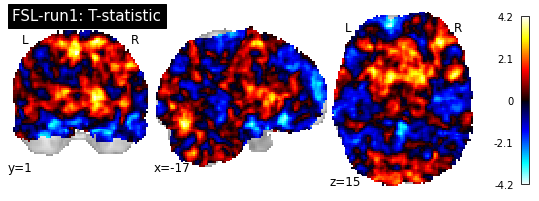

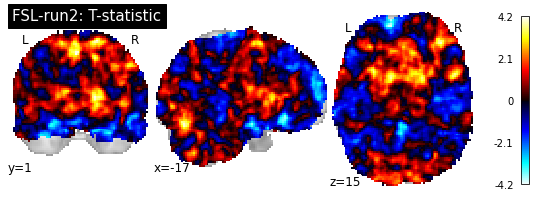

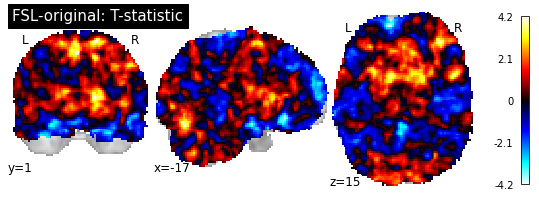

In [35]:
def plot_stat_images(fsl_stat_file_run1, fsl_stat_file_run2, max_activation, array, Title, fsl_stat_file_orig=None):
    plotting.plot_stat_map(fsl_stat_file_run1, vmax=max_activation, title="FSL-run1: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.plot_stat_map(fsl_stat_file_run2, vmax=max_activation, title="FSL-run2: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    if fsl_stat_file_orig is not None:
        plotting.plot_stat_map(fsl_stat_file_orig, vmax=max_activation, title="FSL-original: " + Title, display_mode='ortho', cut_coords=array, draw_cross=False)
    plotting.show()

print("Replication of the original experiment")
max_activation=4.2
plot_stat_images(fsl_stat_replicate1, fsl_stat_replicate2, max_activation, [-17, 1, 15], 'T-statistic', fsl_stat_orig)


Replication of the original experiment



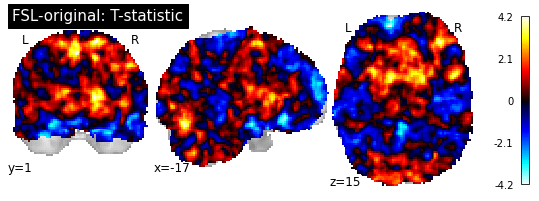

In [36]:
print("Replication of the original experiment")
# convert -loop 0 1.png 2.png group-level-fsl.gif
def show_gif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif('./figures/group-level-fsl.gif')

Intrumented results at virtual precision 53 bits


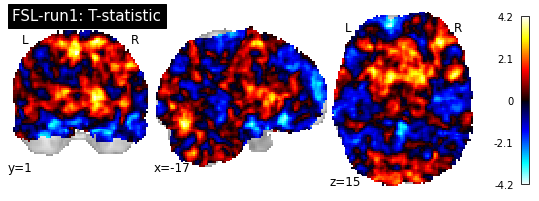

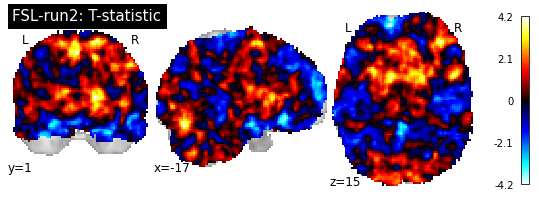

In [38]:
study = 'instrumented/p53-run1/'
fsl_stat_run1 = fsl_stat(study)
study = 'instrumented/p53-run2/'
fsl_stat_run2 = fsl_stat(study)

print("Intrumented results at virtual precision 53 bits")
max_activation=4.2
plot_stat_images(fsl_stat_run1, fsl_stat_run2, max_activation, [-17, 1, 15], 'T-statistic')


Intrumented results at virtual precision 53 bits



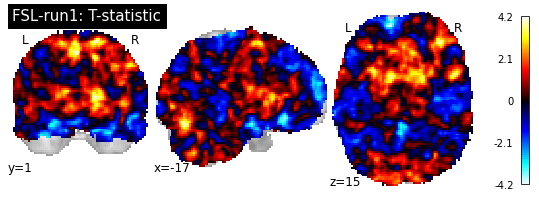

In [39]:
print("Intrumented results at virtual precision 53 bits")
show_gif('./figures/group-level-fsl-p53.gif')

## First level analysis - indivisual preprocessing